Single deep tree: mean=0.9231, std=0.0099, min=0.9091, max=0.9371
Bagging (trees): mean=0.9515, std=0.0041, min=0.9441, max=0.9580
Random forest: mean=0.9580, std=0.0000, min=0.9580, max=0.9580


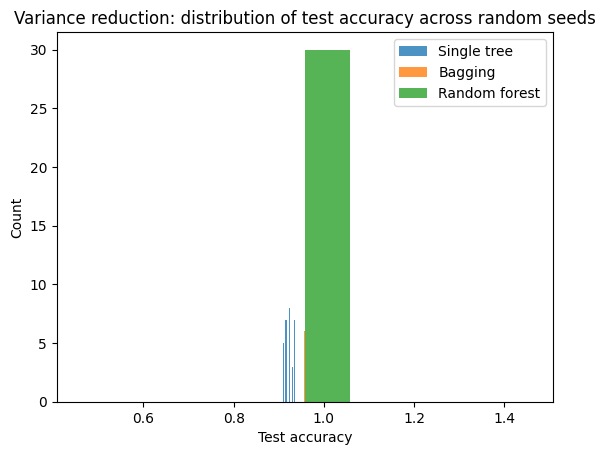

/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


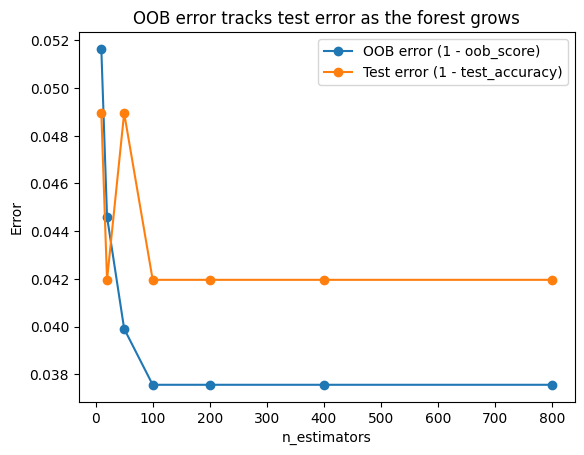

max_features=sqrt | oob_acc=0.9624 | test_acc=0.9580 | avg_tree_corr≈0.7966
max_features=log2 | oob_acc=0.9554 | test_acc=0.9580 | avg_tree_corr≈0.7904
max_features=None | oob_acc=0.9577 | test_acc=0.9510 | avg_tree_corr≈0.8159
max_features= 0.3 | oob_acc=0.9624 | test_acc=0.9580 | avg_tree_corr≈0.8117
max_features= 0.1 | oob_acc=0.9624 | test_acc=0.9580 | avg_tree_corr≈0.7729


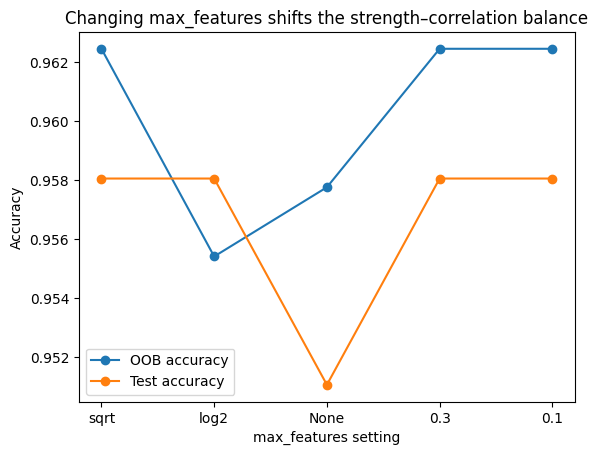

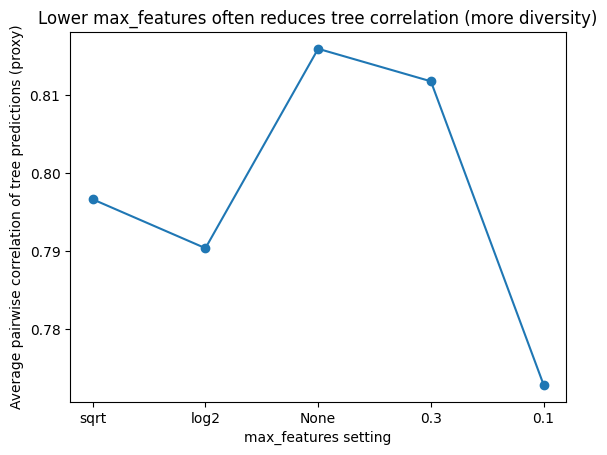


Bagging:
  OOB accuracy: 0.960093896713615
  Test accuracy: 0.951048951048951

Random Forest:
  OOB accuracy: 0.9624413145539906
  Test accuracy: 0.958041958041958


In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier


X, y = load_breast_cancer(return_X_y=True)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)


def make_bagging_tree(n_estimators=200, random_state=0, max_samples=1.0):
    tree = DecisionTreeClassifier(
        random_state=random_state,
        max_depth=None,            # allow deep trees (high variance base learner)
        min_samples_leaf=1
    )
    try:
        # sklearn >= 1.2-ish
        return BaggingClassifier(
            estimator=tree,
            n_estimators=n_estimators,
            bootstrap=True,
            oob_score=True,
            max_samples=max_samples,
            n_jobs=-1,
            random_state=random_state
        )
    except TypeError:
        # sklearn older
        return BaggingClassifier(
            base_estimator=tree,
            n_estimators=n_estimators,
            bootstrap=True,
            oob_score=True,
            max_samples=max_samples,
            n_jobs=-1,
            random_state=random_state
        )


def fit_and_score(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    yhat = model.predict(X_test)
    return accuracy_score(y_test, yhat)

R = 30  # number of repeated runs with different seeds
single_tree_scores = []
bagging_scores = []
rf_scores = []

for seed in range(R):
    # Single deep tree
    tree = DecisionTreeClassifier(random_state=seed, max_depth=None, min_samples_leaf=1)
    single_tree_scores.append(fit_and_score(tree, X_train, y_train, X_test, y_test))

    # Bagging (bootstrap only, no feature randomness)
    bag = make_bagging_tree(n_estimators=300, random_state=seed)
    bagging_scores.append(fit_and_score(bag, X_train, y_train, X_test, y_test))

    # Random forest (bootstrap + feature randomness)
    rf = RandomForestClassifier(
        n_estimators=300,
        bootstrap=True,
        oob_score=True,
        max_features="sqrt",   # typical classification default in many libraries
        n_jobs=-1,
        random_state=seed
    )
    rf_scores.append(fit_and_score(rf, X_train, y_train, X_test, y_test))

def summarize(name, scores):
    scores = np.array(scores)
    print(f"{name}: mean={scores.mean():.4f}, std={scores.std(ddof=1):.4f}, min={scores.min():.4f}, max={scores.max():.4f}")

summarize("Single deep tree", single_tree_scores)
summarize("Bagging (trees)", bagging_scores)
summarize("Random forest", rf_scores)

plt.figure()
plt.hist(single_tree_scores, bins=10, alpha=0.8, label="Single tree")
plt.hist(bagging_scores, bins=10, alpha=0.8, label="Bagging")
plt.hist(rf_scores, bins=10, alpha=0.8, label="Random forest")
plt.xlabel("Test accuracy")
plt.ylabel("Count")
plt.legend()
plt.title("Variance reduction: distribution of test accuracy across random seeds")
plt.show()


def oob_curve(model_factory, n_list):
    oobs = []
    tests = []
    for n in n_list:
        model = model_factory(n)
        model.fit(X_train, y_train)
        # OOB score is an accuracy estimate on training points using only trees that did not see each point
        oobs.append(getattr(model, "oob_score_", np.nan))
        tests.append(accuracy_score(y_test, model.predict(X_test)))
    return np.array(oobs), np.array(tests)

n_list = [10, 20, 50, 100, 200, 400, 800]

# Random forest factory
def rf_factory(n):
    return RandomForestClassifier(
        n_estimators=n,
        bootstrap=True,
        oob_score=True,
        max_features="sqrt",
        n_jobs=-1,
        random_state=42
    )

rf_oob, rf_test = oob_curve(rf_factory, n_list)

plt.figure()
plt.plot(n_list, 1 - rf_oob, marker="o", label="OOB error (1 - oob_score)")
plt.plot(n_list, 1 - rf_test, marker="o", label="Test error (1 - test_accuracy)")
plt.xlabel("n_estimators")
plt.ylabel("Error")
plt.title("OOB error tracks test error as the forest grows")
plt.legend()
plt.show()

def avg_pairwise_tree_pred_correlation(forest, X_eval):
    """
    Rough diversity proxy: compute average pairwise correlation of tree predictions.
    For binary classification we encode predictions as {0,1} and compute Pearson corr.
    """
    preds = np.array([est.predict(X_eval) for est in forest.estimators_])  # shape: (n_trees, n_samples)
    preds = preds.astype(float)
    # Center each tree's predictions
    preds = preds - preds.mean(axis=1, keepdims=True)
    # Correlation matrix between trees (n_trees x n_trees)
    cov = preds @ preds.T
    denom = np.sqrt(np.diag(cov)[:, None] * np.diag(cov)[None, :])
    with np.errstate(divide="ignore", invalid="ignore"):
        corr = cov / denom
    # Take upper triangle without diagonal
    n_trees = corr.shape[0]
    iu = np.triu_indices(n_trees, k=1)
    vals = corr[iu]
    vals = vals[~np.isnan(vals)]
    return float(vals.mean()) if len(vals) else np.nan

max_features_grid = ["sqrt", "log2", None, 0.3, 0.1]  # None means use all features in sklearn
results = []

for mf in max_features_grid:
    rf = RandomForestClassifier(
        n_estimators=400,
        bootstrap=True,
        oob_score=True,
        max_features=mf,
        n_jobs=-1,
        random_state=42
    )
    rf.fit(X_train, y_train)
    test_acc = accuracy_score(y_test, rf.predict(X_test))
    oob_acc = rf.oob_score_
    corr = avg_pairwise_tree_pred_correlation(rf, X_test)
    results.append((str(mf), oob_acc, test_acc, corr))

for mf, oob_acc, test_acc, corr in results:
    print(f"max_features={mf:>4} | oob_acc={oob_acc:.4f} | test_acc={test_acc:.4f} | avg_tree_corr≈{corr:.4f}")

# Plot performance vs max_features setting
labels = [r[0] for r in results]
oob_vals = [r[1] for r in results]
test_vals = [r[2] for r in results]
corr_vals = [r[3] for r in results]

plt.figure()
plt.plot(labels, oob_vals, marker="o", label="OOB accuracy")
plt.plot(labels, test_vals, marker="o", label="Test accuracy")
plt.xlabel("max_features setting")
plt.ylabel("Accuracy")
plt.title("Changing max_features shifts the strength–correlation balance")
plt.legend()
plt.show()

plt.figure()
plt.plot(labels, corr_vals, marker="o")
plt.xlabel("max_features setting")
plt.ylabel("Average pairwise correlation of tree predictions (proxy)")
plt.title("Lower max_features often reduces tree correlation (more diversity)")
plt.show()

bag = make_bagging_tree(n_estimators=400, random_state=42)
bag.fit(X_train, y_train)

rf = RandomForestClassifier(
    n_estimators=400,
    bootstrap=True,
    oob_score=True,
    max_features="sqrt",
    n_jobs=-1,
    random_state=42
)
rf.fit(X_train, y_train)

print("\nBagging:")
print("  OOB accuracy:", bag.oob_score_)
print("  Test accuracy:", accuracy_score(y_test, bag.predict(X_test)))

print("\nRandom Forest:")
print("  OOB accuracy:", rf.oob_score_)
print("  Test accuracy:", accuracy_score(y_test, rf.predict(X_test)))
